# Taller 1 (Agentes)

1. Recrear el sistemas de agentes que negocian con dinero. (Notebook: sma-1). De este sistema, realice las siguientes acciones:
    *   Defina una función que modele el comportamiento de los agentes
    *   Describa cuale es el comportamiento del sistema multi agente
    *   Varie los parametros del modelo para que la riqueza inicial no sea fija. ¿Cuál es el comportamiento del modelo?
    *   Compare los resultados con el modelo inicial
2. Con el sistema sma-1 crear una estrategia para que la distribución de la riqueza sea justa para todos los agentes. (Compare los resultados con el sistema sma-1)
3. Con el sistema sma-1 compare el comportamiento de la riqueza de los primeros 50 agentes. ¿Cuál es la diferencia relavante?
4. Diseñe un sistema multi agente, que tengan 10 agentes. Los 10 agentes intercambien mensajes. Los mensajes son cadenas de texto aleatorio. Imprima los mensajes.
5. Analice el sistema multi agente de expansión de virus en una red. Despliegue el modelo describa los siguientes aspectos:
    * Defina el PEAS de los agentes (Ejecute pruebas para demostrar sus argumentos)
    * Defina el tipo de ambiente. (Ejecute pruebas para demostrar sus argumentos)
    * Definan los componentes de los agentes de ese sistema multi agente
    * Simule el comportamiento del COVID 19 con este sistema multi agente. (Ejecute pruebas para demostrar sus argumentos)


**Integrantes**
- Daniel Andrade | ✉ daniel.andrade01@correo.usa.edu.co
- Gabriel Cubides | ✉ gabriel.cubides01@correo.usa.edu.co
- Dewith Miramón | ✉ dewith.miramon01@correo.usa.edu.co
- Santiago Prado | ✉ santiago.prado01@correo.usa.edu.co

In [ ]:
try:
    from mesa import Agent
except Exception:
    ! pip install mesa

     |████████████████████████████████| 691 kB 34.0 MB/s 
     |████████████████████████████████| 1.9 MB 71.8 MB/s 
     |████████████████████████████████| 178 kB 67.3 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
import matplotlib.pyplot as plt

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint, choice
import gc

In [ ]:
sns.set_style("dark")

## Punto 1
**Recrear el sistemas de agentes que negocian con dinero. (Notebook: sma-1). De este sistema, realice las siguientes acciones:**
*   Defina una función que modele el comportamiento de los agentes
*   Describa cuale es el comportamiento del sistema multi agente
*   Varie los parametros del modelo para que la riqueza inicial no sea fija. ¿Cuál es el comportamiento del modelo?
*   Compare los resultados con el modelo inicial

In [ ]:
# Métricas de evaluación
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


In [ ]:
class MoneyAgent(Agent):
    """Un agente con una riqueza inicial aleatoria."""

    def __init__(self, unique_id, range_wealth, model):
        super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.wealth = randint(int(range_wealth[0]), int(range_wealth[1]))

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
            
    def __repr__(self):
        return f"Agent #{self.unique_id} with ${self.wealth} at {self.pos}"


class MoneyModel(Model):
    """Un modelo con cierto número de agentes."""

    def __init__(self, N, range_wealth, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Crear agentes
        for i in range(self.num_agents):
            a = MoneyAgent(i, range_wealth, self)
            self.schedule.add(a)
            # Añadir el agente a una celda aleatoria de la cuadrícula
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #print(repr(a))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


### Modelo con wealth constante

In [ ]:
%%time
params = {
    "N": range(10, 500, 20),
    "range_wealth": [(1, 1)],
    "width": 10,
    "height": 10, 
}

results_baseline = batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=None,
    data_collection_period=1,
    display_progress=True,
)

125it [00:40,  3.09it/s]CPU times: user 6.23 s, sys: 890 ms, total: 7.12 s
Wall time: 40.5 s



In [ ]:
results_baseline_df = pd.DataFrame(results_baseline)
del results_baseline
results_baseline_df.head(7)

,RunId,iteration,Step,N,range_wealth,width,height,Gini,AgentID,Wealth
0,0,0,0,10,"(1, 1)",10,10,0.0,0,1
1,0,0,0,10,"(1, 1)",10,10,0.0,1,1
2,0,0,0,10,"(1, 1)",10,10,0.0,2,1
3,0,0,0,10,"(1, 1)",10,10,0.0,3,1
4,0,0,0,10,"(1, 1)",10,10,0.0,4,1
5,0,0,0,10,"(1, 1)",10,10,0.0,5,1
6,0,0,0,10,"(1, 1)",10,10,0.0,6,1


In [ ]:
results_baseline_filtered = results_baseline_df[(results_baseline_df.AgentID == 0) &
                                                (results_baseline_df.Step == 100)]
N_values = results_baseline_filtered.N.values
gini_values = results_baseline_filtered.Gini.values

Text(0, 0.5, 'Gini')

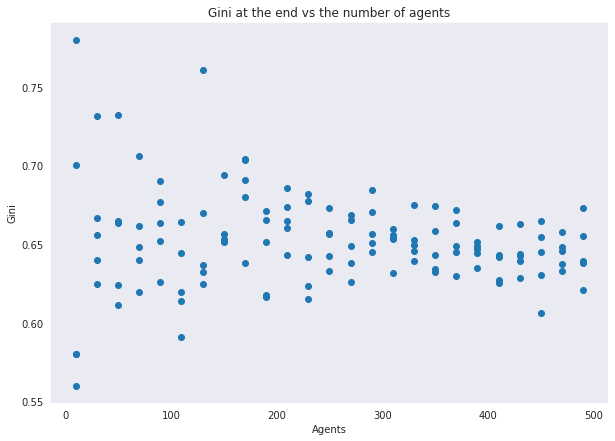

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(N_values, gini_values)
plt.title('Gini at the end vs the number of agents')
plt.xlabel('Agents')
plt.ylabel('Gini')

Text(0.5, 1.0, 'Mean gini vs step')

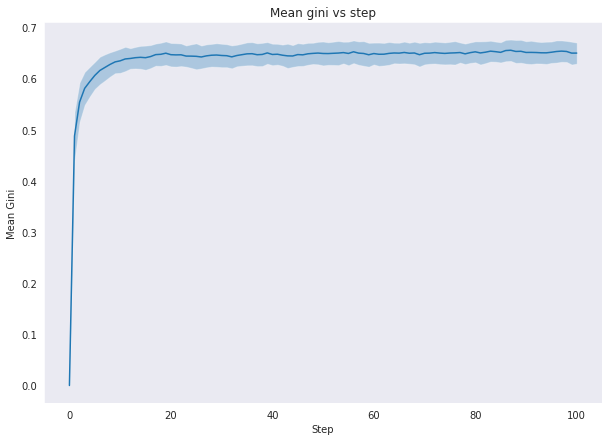

In [ ]:
ginis_baseline_steps = results_baseline_df.groupby('Step').agg({'Gini': ['mean', 'std']})
mean_gini_vec = np.array(ginis_baseline_steps[('Gini', 'mean')])
std_gini_vec = np.array(ginis_baseline_steps[('Gini', 'std')])

x_axis = ginis_baseline_steps.index
lower_bound = mean_gini_vec - std_gini_vec
upper_bound = mean_gini_vec + std_gini_vec

plt.figure(figsize=(10, 7))
sns.lineplot(x=x_axis, y=mean_gini_vec, markers=True, dashes=False)
plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3)
plt.xlabel('Step')
plt.ylabel('Mean Gini')
plt.title('Mean gini vs step')

In [ ]:
gc.collect()

62

### Modelo con wealth aleatorio

In [ ]:
%%time
params = {
    "N": range(10, 500, 20),
    "range_wealth": [(0, 10)],
    "width": 10,
    "height": 10, 
}

results_random = batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=None,
    data_collection_period=1,
    display_progress=True,
)

125it [00:45,  2.77it/s]CPU times: user 6.16 s, sys: 1 s, total: 7.17 s
Wall time: 45.1 s



In [ ]:
results_random_df = pd.DataFrame(results_random)
del results_random
results_random_df.head(7)

,RunId,iteration,Step,N,range_wealth,width,height,Gini,AgentID,Wealth
0,0,0,0,10,"(0, 10)",10,10,0.189655,0,4
1,0,0,0,10,"(0, 10)",10,10,0.189655,1,3
2,0,0,0,10,"(0, 10)",10,10,0.189655,2,4
3,0,0,0,10,"(0, 10)",10,10,0.189655,3,3
4,0,0,0,10,"(0, 10)",10,10,0.189655,4,4
5,0,0,0,10,"(0, 10)",10,10,0.189655,5,0
6,0,0,0,10,"(0, 10)",10,10,0.189655,6,3


In [ ]:
results_random_filtered = results_random_df[(results_random_df.AgentID == 0) & 
                                            (results_random_df.Step == 100)]
N_values_random = results_random_filtered.N.values
gini_values_random = results_random_filtered.Gini.values

Text(0, 0.5, 'Gini')

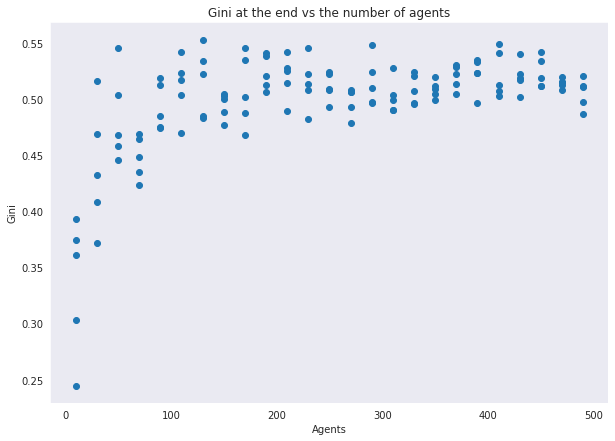

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(N_values_random, gini_values_random)
plt.title('Gini at the end vs the number of agents')
plt.xlabel('Agents')
plt.ylabel('Gini')

Text(0.5, 1.0, 'Mean gini vs step')

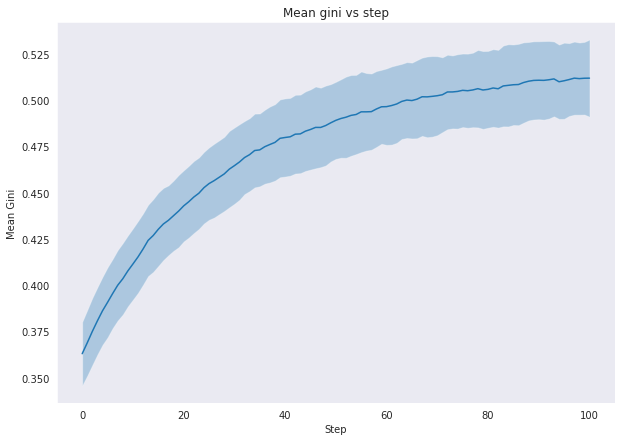

In [ ]:
ginis_random_steps = results_random_df.groupby('Step').agg({'Gini': ['mean', 'std']})
mean_gini_vec = np.array(ginis_random_steps[('Gini', 'mean')])
std_gini_vec = np.array(ginis_random_steps[('Gini', 'std')])

x_axis = ginis_random_steps.index
lower_bound = mean_gini_vec - std_gini_vec
upper_bound = mean_gini_vec + std_gini_vec

plt.figure(figsize=(10, 7))
sns.lineplot(x=x_axis, y=mean_gini_vec, markers=True, dashes=False)
plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3)
plt.xlabel('Step')
plt.ylabel('Mean Gini')
plt.title('Mean gini vs step')

In [ ]:
gc.collect()

62

## Punto 2
**Con el sistema sma-1 crear una estrategia para que la distribución de la riqueza sea justa para todos los agentes. (Compare los resultados con el sistema sma-1)**

In [ ]:
class MoneyAgent(Agent):
    """Un agente con una riqueza inicial aleatoria."""

    def __init__(self, unique_id, range_wealth, model):
        super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.wealth = randint(int(range_wealth[0]), int(range_wealth[1]))

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            if self.wealth < self.model.meanglobalwealth:
                pass
            else:
                for cellmate in cellmates:
                    if cellmate.wealth >= self.model.meanglobalwealth:
                        continue
                    else:
                        cellmate.wealth += 1
                        self.wealth -= 1
                        break

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
            
    def __repr__(self):
        return f"Agent #{self.unique_id} with ${self.wealth} at {self.pos}"


class MoneyModel(Model):
    """Un modelo con cierto número de agentes."""

    def __init__(self, N, range_wealth, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.globalwealth=0

        # Crear agentes
        for i in range(self.num_agents):
            a = MoneyAgent(i, range_wealth, self)
            self.schedule.add(a)
            # Añadir el agente a una celda aleatoria de la cuadrícula
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            self.globalwealth+=a.wealth

        self.meanglobalwealth = self.globalwealth/self.num_agents
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [ ]:
%%time
params = {
    "N": range(10, 500, 20),
    "range_wealth": [(0, 10)],
    "width": 10,
    "height": 10, 
}

results_comm = batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=None,
    data_collection_period=1,
    display_progress=True,
)

125it [00:44,  2.79it/s]CPU times: user 6.2 s, sys: 1.01 s, total: 7.21 s
Wall time: 44.8 s



In [ ]:
results_comm_df = pd.DataFrame(results_comm)
del results_comm
results_comm_df.head(5)

,RunId,iteration,Step,N,range_wealth,width,height,Gini,AgentID,Wealth
0,0,0,0,10,"(0, 10)",10,10,0.296078,0,6
1,0,0,0,10,"(0, 10)",10,10,0.296078,1,0
2,0,0,0,10,"(0, 10)",10,10,0.296078,2,9
3,0,0,0,10,"(0, 10)",10,10,0.296078,3,5
4,0,0,0,10,"(0, 10)",10,10,0.296078,4,7


In [ ]:
results_comm_filtered = results_comm_df[(results_comm_df.AgentID == 0) & 
                                            (results_comm_df.Step == 100)]
N_values_comm = results_comm_filtered.N.values
gini_values_comm = results_comm_filtered.Gini.values

Text(0, 0.5, 'Gini')

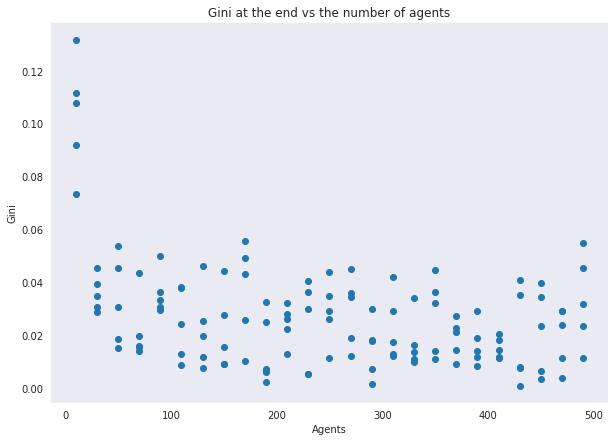

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(N_values_comm, gini_values_comm)
plt.title('Gini at the end vs the number of agents')
plt.xlabel('Agents')
plt.ylabel('Gini')

Text(0.5, 1.0, 'Mean gini vs step')

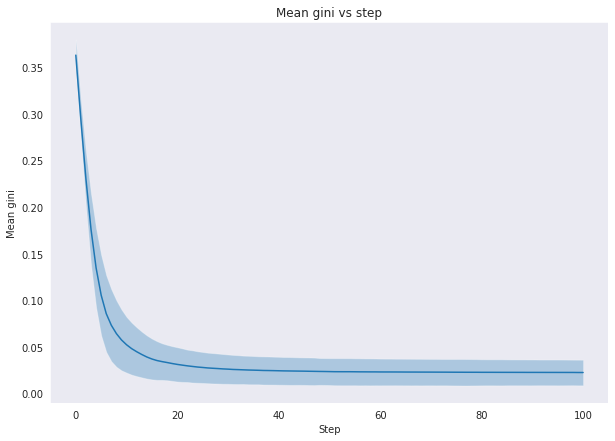

In [ ]:
ginis_comm_steps = results_comm_df.groupby('Step').agg({'Gini': ['mean', 'std']})
mean_gini_vec = np.array(ginis_comm_steps[('Gini', 'mean')])
std_gini_vec = np.array(ginis_comm_steps[('Gini', 'std')])

x_axis = ginis_comm_steps.index
lower_bound = mean_gini_vec - std_gini_vec
upper_bound = mean_gini_vec + std_gini_vec

plt.figure(figsize=(10, 7))
sns.lineplot(x=x_axis, y=mean_gini_vec, markers=True, dashes=False)
plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3)
plt.xlabel('Step')
plt.ylabel('Mean gini')
plt.title('Mean gini vs step')

In [ ]:
gc.collect()

62

## Punto 3
**Con el sistema sma-1 compare el comportamiento de la riqueza de los primeros 50 agentes. ¿Cuál es la diferencia relevante?**

In [ ]:
per_agent = results_comm_df[results_comm_df['AgentID'] <= 50]
per_agent = per_agent.groupby(['AgentID', 'Step']).mean()

<AxesSubplot:xlabel='Step', ylabel='Wealth'>

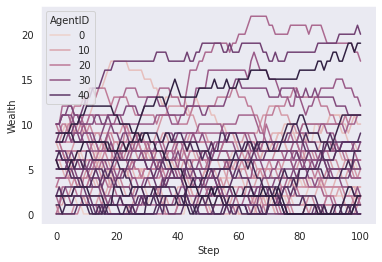

In [ ]:
#plt.figure(figsize=(20,10))
sns.lineplot(x='Step', y='Wealth', data=per_agent, hue='AgentID')

## Punto 4
**Diseñe un sistema multi agente, que tengan 10 agentes. Los 10 agentes intercambien mensajes. Los mensajes son cadenas de texto aleatorio. Imprima los mensajes.**

In [ ]:
class MessengerAgent(Agent):
    """Un agente mensajero que envía mensajes aleatorios"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
            
        # Añadir el agente a una celda aleatoria de la cuadrícula
        model.schedule.add(self)
        x = model.random.randrange(model.grid.width)
        y = model.random.randrange(model.grid.height)
        model.grid.place_agent(self, (x, y))

        self.unique_id = unique_id
        self.message = ''.join(choice(model.letters) for i in range(10))
        self.sent_counter = 0
        self.received_message = None
        self.x = self.pos[0]
        self.y = self.pos[1]
    
    def move(self):
        past_pos = (self.pos[0], self.pos[1])
        while True:
            move_x = choice([-1, 0, 1])
            move_y = choice([-1, 0, 1])
            new_x = self._clean_pos(int(past_pos[0]) + move_x, side='width')
            new_y = self._clean_pos(int(past_pos[1]) + move_y, side='height')
            new_pos = (new_x, new_y)
            if ((move_x != 0 or move_y != 0) and 
                (new_pos != past_pos)):
                break 

        self.model.grid.move_agent(self, new_pos)
        self.x = self.pos[0]
        self.y = self.pos[1] 

    def _clean_pos(self, coordinate, side):
        if side == 'width':
            max = model.grid.width - 1
        elif side == 'height':
            max = model.grid.height - 1

        if coordinate > max:
            return max
        elif coordinate < 0:
            return 0
        else:
            return coordinate

    def send_message(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            if self is not other_agent:
              other_agent.received_message = self.message
              self.sent_counter += 1
              print(f'\tAgent #{self.unique_id} sent "{self.message}" to '
                    f'agent #{other_agent.unique_id} at {self.pos}')

    def step(self):
        self.move()
        self.send_message()
        
    def __repr__(self):
        return f'\tAgent #{self.unique_id} with message "{self.message}" at {self.pos}'


class MessengerModel(Model):
    """Un modelo con cierto número de agentes."""
    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.letters = string.ascii_letters

        # Crear agentes
        print('-' * 60)
        print('Initialization')
        print(f'Grid: {model.grid.width}x{model.grid.height}')
        print(f'No agents: {N}')
        for i in range(self.num_agents):
            agent = MessengerAgent(i, self)
            print(repr(agent))
        print('-' * 60)

        self.datacollector = DataCollector(
            model_reporters={}, 
            agent_reporters={"Message": "message",
                             "Messages sent": "sent_counter",
                             "Last message": "received_message",
                             "X": 'x',
                             "Y": 'y'}
        )
        self.received_message = None

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [ ]:
model = MessengerModel(N=10, width=5, height=5)
for step in range(10):
    print(f'Step {step + 1}')
    model.step()

------------------------------------------------------------
Initialization


NameError: name 'model' is not defined

In [ ]:
messenger_agent_metrics = model.datacollector.get_agent_vars_dataframe()
last_step = messenger_agent_metrics.xs(9, level='Step').sort_values('Messages sent', ascending=False)
last_step

,Message,Messages sent,Last message,X,Y
AgentID,,,,,
6,QuorKtDTzC,4,None,3,4
8,vFdMRpHqaT,3,QTAiyjVoxm,2,0
9,jaMWlKxAQT,3,FiOTPYoGXH,3,4
5,PMaUljidXS,2,LVTpbaVpAC,3,1
7,FiOTPYoGXH,2,QuorKtDTzC,3,4
1,gRrIDPkMII,1,QuorKtDTzC,2,3
3,LVTpbaVpAC,1,QuorKtDTzC,4,2
4,QTAiyjVoxm,1,jaMWlKxAQT,3,2
0,dfiwOiItpr,0,jaMWlKxAQT,4,3


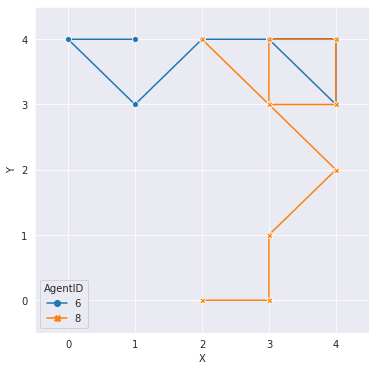

In [ ]:
best_agents_ids = list(last_step.index[:2])
best_agents = messenger_agent_metrics.reset_index().query("AgentID in @best_agents_ids")

plt.figure(figsize=(6, 6))
sns.lineplot(x='X', y='Y', data=best_agents, 
             hue='AgentID', style="AgentID",
             estimator=None, ci=None, 
             markers=True, dashes=False,
             palette="tab10",
             sort=False)
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, 4.5)
plt.grid(which='major')

In [ ]:
print('Agent:', best_agents_ids[0])
messenger_agent_metrics.xs(best_agents_ids[0], level='AgentID')

Agent: 6


,Message,Messages sent,Last message,X,Y
Step,,,,,
0,QuorKtDTzC,0,None,1,4
1,QuorKtDTzC,0,None,0,4
2,QuorKtDTzC,1,None,1,3
3,QuorKtDTzC,2,None,2,4
4,QuorKtDTzC,2,None,3,4
5,QuorKtDTzC,2,None,4,4
6,QuorKtDTzC,2,None,3,4
7,QuorKtDTzC,2,None,4,4
8,QuorKtDTzC,3,None,4,3


## Punto 5
**Analice el sistema multi agente de expansión de virus en una red. Despliegue el modelo describa los siguientes aspectos:**
* Defina el PEAS de los agentes (Ejecute pruebas para demostrar sus argumentos)
* Defina el tipo de ambiente. (Ejecute pruebas para demostrar sus argumentos)
* Definan los componentes de los agentes de ese sistema multi agente
* Simule el comportamiento del COVID 19 con este sistema multi agente. (Ejecute pruebas para demostrar sus argumentos)


In [ ]:
from mesa import Agent
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import gc

In [ ]:
sns.set_style("dark")

In [ ]:
# Métricas de evaluación
def resistant(model):
    agent_wealths = [agent.is_resistant for agent in model.schedule.agents]
    return sum(agent_wealths)

def susceptible(model):
    agent_wealths = [not agent.is_infected and not agent.is_resistant for agent in model.schedule.agents]
    return sum(agent_wealths)
    
def infected(model):    
    agent_wealths = [agent.is_infected for agent in model.schedule.agents]
    return sum(agent_wealths)

In [ ]:
class MoneyAgent(Agent):

    def __init__(self, unique_id, spread_probability, initial, recuperation_days,resistance_probability,model):
        super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.is_infected = True if unique_id < initial else False
        self.days_infected = 0
        self.is_resistant = False
        self.spread_probability = spread_probability
        self.recuperation_days = recuperation_days
        self.resistance_probability = resistance_probability

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore = True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def spread_virus(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for cellmate in cellmates:
            if cellmate.unique_id != self.unique_id:
                if not cellmate.is_infected and not cellmate.is_resistant:
                    cellmate.is_infected= True if random.random() < cellmate.spread_probability else False


    def step(self):
        self.move()

        if self.is_infected:
            self.days_infected+=1
            if self.days_infected <= self.recuperation_days:
                self.spread_virus()
            else:
                self.days_infected = 0
                self.is_infected = False
                self.is_resistant = True if random.random() < self.resistance_probability else False
            
    def __repr__(self):
        return f"Agent #{self.unique_id} at {self.pos}"


class MoneyModel(Model):
    """Un modelo con cierto número de agentes."""

    def __init__(self, N, width, height, spread_probability, initial, recuperation_days,resistance_probability):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Crear agentes
        
        for i in range(self.num_agents):

            a = MoneyAgent(i, spread_probability, initial, recuperation_days,resistance_probability,self)
            self.schedule.add(a)
            
            # Añadir el agente a una celda aleatoria de la cuadrícula

            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters = {"resistant_total": resistant,"susceptible_total":susceptible,"infected_total":infected}, 
            agent_reporters = {"infected": "is_infected","resistant":"is_resistant","days_infected":"days_infected"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [ ]:
%%time
params = {
    "N":30,
    "width":3,
    "height":3,
    "spread_probability": 0.4,
    "initial": 3,
    "recuperation_days": 8,
    "resistance_probability": 0.5 
}

results_comm = batch_run(
    MoneyModel,
    parameters=params,
    iterations=1,
    max_steps=40,
    number_processes=None,
    data_collection_period=1,
    display_progress=True,
)

1it [00:00,  6.55it/s]CPU times: user 11.6 ms, sys: 26 ms, total: 37.5 ms
Wall time: 157 ms



In [ ]:
results_comm_df = pd.DataFrame(results_comm)

In [ ]:
res=results_comm_df[["Step","resistant_total","susceptible_total","infected_total"]].drop_duplicates()
res.reset_index(inplace=True,drop=True)
res.drop(["Step"], axis=1,inplace=True)

<AxesSubplot:>

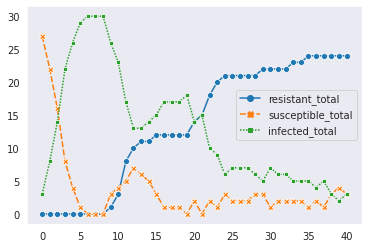

In [ ]:
sns.lineplot(data=res,markers=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=488854b2-98ba-45f1-b6c3-7925cc0707d4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>